In [188]:
import pickle
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import glob
import gensim
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from pyvi import ViTokenizer, ViPosTagger
from tqdm import tqdm

# Read the raw data

In [189]:
dir_path = os.path.dirname(os.path.realpath(os.getcwd()))

def get_data(folder_path):
    X = []
    y = []
    dirs = os.listdir(folder_path)
    for path in tqdm(dirs):
        file_paths = os.listdir(os.path.join(folder_path, path))
        for file_path in tqdm(file_paths):
            with open(os.path.join(folder_path, path, file_path), 'r', encoding="utf-8") as f:
                lines = f.readlines()
                lines = ' '.join(lines)
                lines = gensim.utils.simple_preprocess(lines)
                lines = ' '.join(lines)
                lines = ViTokenizer.tokenize(lines)

                X.append(lines)
                y.append(path)

    return X, y

data_path = os.path.join(dir_path, 'dataset/Dataset-Group-4_Vietnamese-News-Classification')


In [190]:
X, y = get_data(data_path)

100%|██████████| 11/11 [01:06<00:00,  6.04s/it]


In [191]:
pickle.dump(X, open('../dataset/processed-data/X.pkl', 'wb'))
pickle.dump(y, open('../dataset/processed-data/y.pkl', 'wb'))

# 1. Formatting the initial dataset

In [192]:
X = pd.read_pickle("../dataset/processed-data/X.pkl")
y = pd.read_pickle("../dataset/processed-data/y.pkl")

X_df = pd.DataFrame(data=X)
y_df = pd.DataFrame(data=y)

for article in X_df:
    X_df.loc[-1] = [article]
    X_df.index += 1

for label in y_df:
    y_df.loc[-1] = [label]
    y_df.index += 1

df = pd.concat([X_df, y_df], axis=1)
df.columns = ['article', 'category']
df = df.drop([0, 0])

In [193]:
df

,article,category
1,twitter kinh_doanh ra sao sau một năm về tay e...,kinh-doanh
2,thương_mại nga trung gần như_không còn dùng us...,kinh-doanh
3,ngân_hàng nhà_nước khó xử_lý sở_hữu chéo nếu c...,kinh-doanh
4,doanh_nghiệp đào_tạo nhân_viên thành tiktoker ...,kinh-doanh
5,khách hỏi mua hàng việt trên alibaba tăng cao ...,kinh-doanh
...,...,...
6762,thanh thảo nhận vé vớt vietnam idol tp hcm tha...,giai-tri
6763,loạt tác_phẩm trừu_tượng màu trắng của trần nữ...,giai-tri
6764,hà_trí quang mang sổ_đỏ tỷ đồng hỏi cưới đồng ...,giai-tri
6765,con_gái xuân_lan diễn loạt show thời_trang bé ...,giai-tri


# 2. Classify by category

### Split by category

- Đời sống
- Du lịch
- Giải trí
- Giáo dục
- Khoa học
- Kinh doanh
- Pháp luật
- Sức khỏe
- Thế giới
- Thể thao
- Thời sự

In [194]:
doi_song_df = df[df['category'] == 'doi-song']
du_lich_df = df[df['category'] == 'du-lich']
giai_tri_df = df[df['category'] == 'giai-tri']
giao_duc_df = df[df['category'] == 'giao-duc']
khoa_hoc_df = df[df['category'] == 'khoa-hoc']
kinh_doanh_df = df[df['category'] == 'kinh-doanh']
phap_luat_df = df[df['category'] == 'phap-luat']
suc_khoe_df = df[df['category'] == 'suc-khoe']
the_gioi_df = df[df['category'] == 'the-gioi']
the_thao_df = df[df['category'] == 'the-thao']
thoi_su_df = df[df['category'] == 'thoi-su']

In [195]:
categories_dict = {'Đời sống' : len(doi_song_df), 
                   'Du lịch' : len(du_lich_df), 
                   'Giải trí' : len(giai_tri_df), 
                   'Giáo dục' : len(giao_duc_df), 
                   'Khoa học' : len(khoa_hoc_df),
                   'Kinh doanh' : len(kinh_doanh_df),
                   'Pháp luật' : len(phap_luat_df),
                   'Sức khỏe' : len(suc_khoe_df),
                   'Thế giới' : len(the_gioi_df),
                   'Thể thao' : len(the_thao_df),
                   'Thời sự' : len(thoi_su_df)}

# 3. Statistical analysis

As you can see:
- The dataset includes 6766 samples. Each sample contains the content of the article and its category.

- There are 11 categories in total.

In [196]:
print("Number of articles: ", len(df['article']))
print("Number of categories: ", df['category'].nunique())

Number of articles:  6766
Number of categories:  11


### Number of articles in different categories

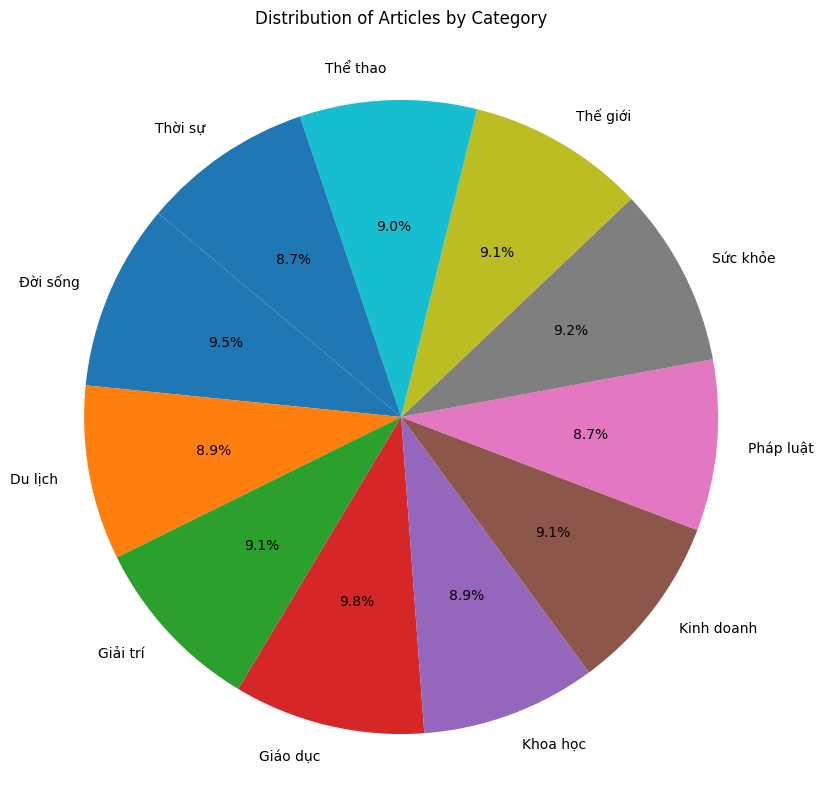

In [201]:
plt.figure(figsize=(9, 10))
plt.pie(categories_dict.values(), labels=categories_dict.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Articles by Category")
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.show()

### Count number of words & characters in each article

In [197]:
df['word_count'] = df['article'].apply(lambda x : len(str(x).split(" ")))
df['char_count'] = df['article'].str.len()                ## This also includes spaces
df[['article', 'word_count', 'char_count']]

,article,word_count,char_count
1,twitter kinh_doanh ra sao sau một năm về tay e...,721,4048
2,thương_mại nga trung gần như_không còn dùng us...,314,1963
3,ngân_hàng nhà_nước khó xử_lý sở_hữu chéo nếu c...,411,2719
4,doanh_nghiệp đào_tạo nhân_viên thành tiktoker ...,531,3606
5,khách hỏi mua hàng việt trên alibaba tăng cao ...,530,3111
...,...,...,...
6762,thanh thảo nhận vé vớt vietnam idol tp hcm tha...,541,3064
6763,loạt tác_phẩm trừu_tượng màu trắng của trần nữ...,696,4225
6764,hà_trí quang mang sổ_đỏ tỷ đồng hỏi cưới đồng ...,386,2104
6765,con_gái xuân_lan diễn loạt show thời_trang bé ...,24,150


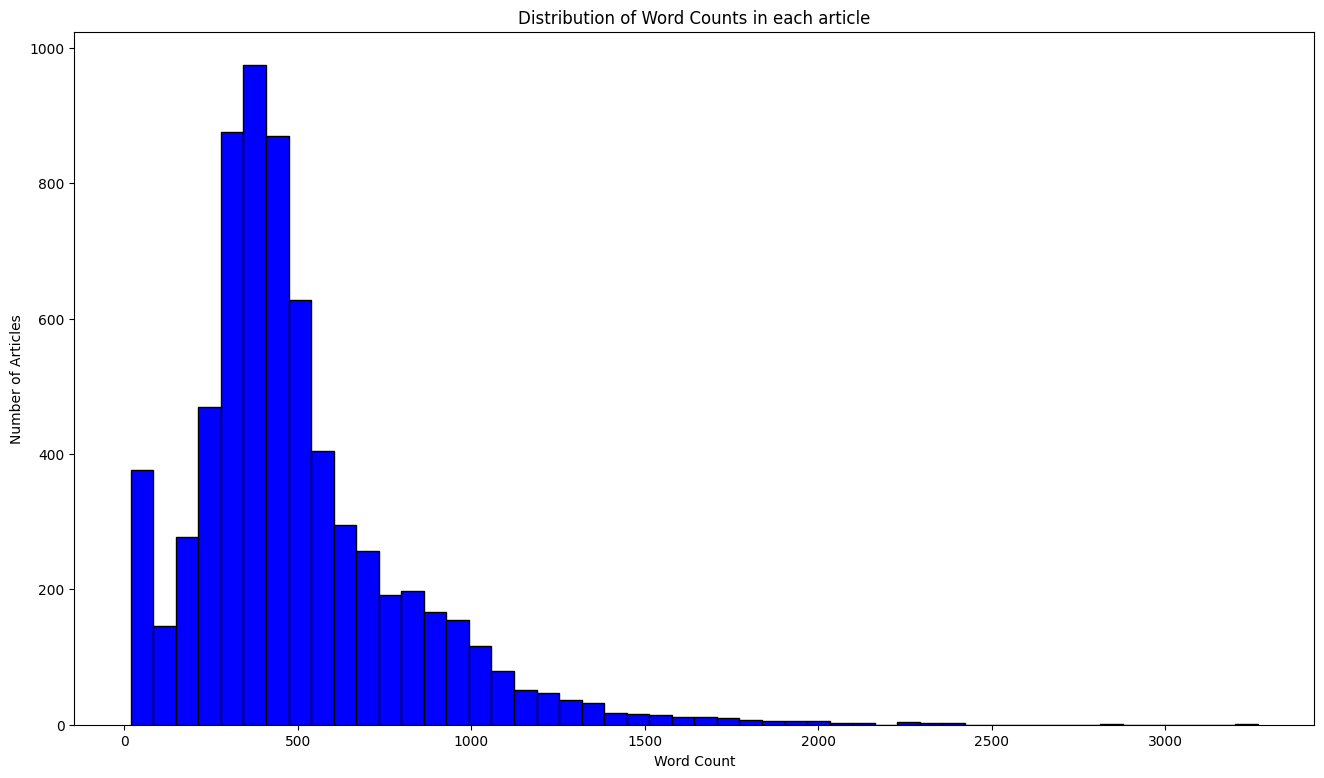

In [198]:
# Histogram: Word counts per article
fig = plt.figure(figsize=(16,9))
plt.hist(df['word_count'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Word Counts in each article')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

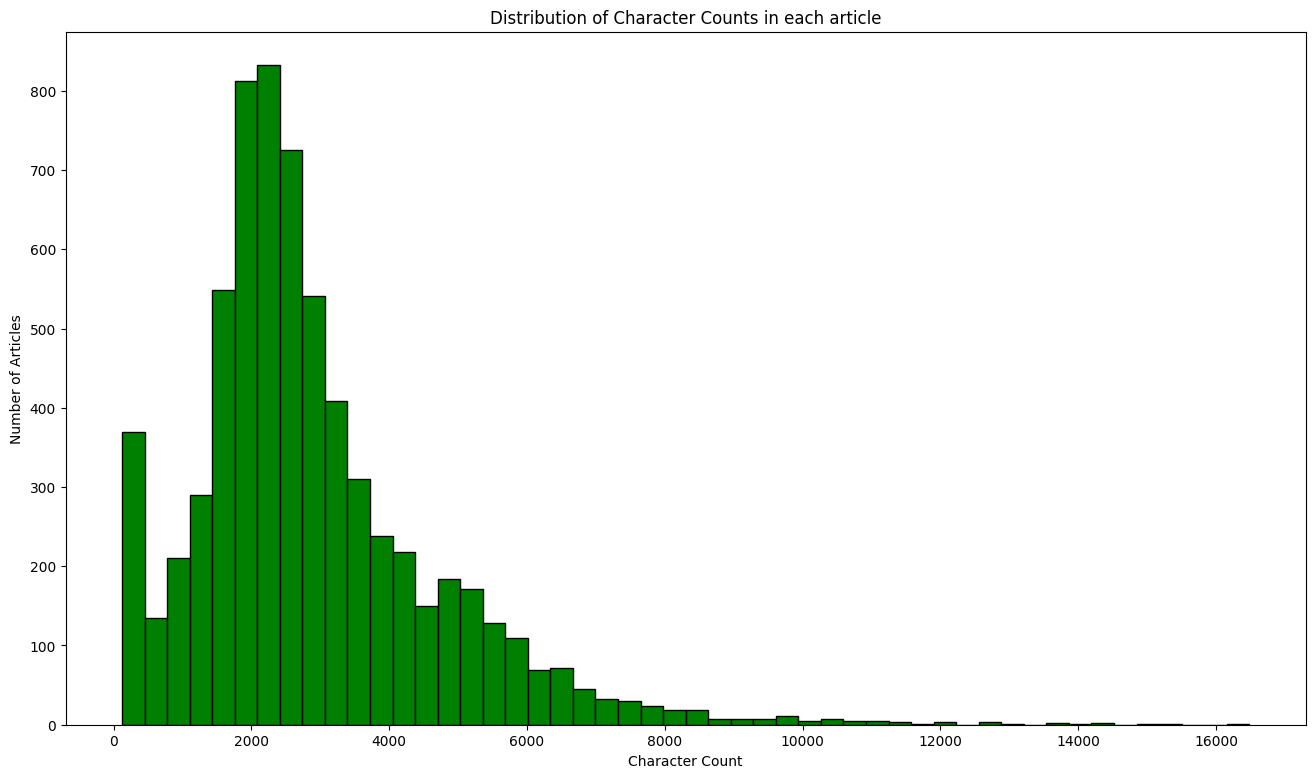

In [199]:
# Histogram: Character counts per article
fig = plt.figure(figsize=(16,9))
plt.hist(df['char_count'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Character Counts in each article')
plt.xlabel('Character Count')
plt.ylabel('Number of Articles')
plt.show()

### Average Word Length of each article

In [202]:
def avg_word(article):
    words = article.split()    
    return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['article'].apply(lambda x: avg_word(x))
df[['article','avg_word']]

,article,avg_word
1,twitter kinh_doanh ra sao sau một năm về tay e...,4.615811
2,thương_mại nga trung gần như_không còn dùng us...,5.254777
3,ngân_hàng nhà_nước khó xử_lý sở_hữu chéo nếu c...,5.618005
4,doanh_nghiệp đào_tạo nhân_viên thành tiktoker ...,5.792844
5,khách hỏi mua hàng việt trên alibaba tăng cao ...,4.871698
...,...,...
6762,thanh thảo nhận vé vớt vietnam idol tp hcm tha...,4.665434
6763,loạt tác_phẩm trừu_tượng màu trắng của trần nữ...,5.071839
6764,hà_trí quang mang sổ_đỏ tỷ đồng hỏi cưới đồng ...,4.453368
6765,con_gái xuân_lan diễn loạt show thời_trang bé ...,5.291667


### Distribution of Stopwords in Articles

#### What is the stopword?
- Stop words are the words in a stop list (or stoplist or negative dictionary) which are filtered out (i.e. stopped) before or after processing of natural language data (text) because they are insignificant.

- We would not want these words to take up space in our database, or taking up valuable processing time. For this, we can remove them easily, by storing a list of words that you consider to stop words.

- But, how to find the list of stop words? In this project, we did:
    - Implement calculation IDF for all words in the dataset
    - Extract the word have IDF <= threshold (in our project, we set threshold = 3).
      And we set (minIDF, maxIDF) = (1.0086982995413565, 13.504312537543813)

In [228]:
stop = []
# Open Vietnamese stopwords dictionary
with open("../vietnamese-stopwords/stopwords.txt") as f:
    for line in f:
        stop.append(line)
f.close()

stop = [sample.replace('\n', '') for sample in stop]
stop

['anh',
 'ba',
 'biết',
 'bà',
 'bán',
 'bên',
 'bạn',
 'bắc',
 'bắt_đầu',
 'bằng',
 'bị',
 'bỏ',
 'bộ',
 'bởi',
 'cao',
 'chia_sẻ',
 'chiều',
 'cho',
 'chuyên_gia',
 'chuyển',
 'châu',
 'chính',
 'chúng_tôi',
 'chưa',
 'chương_trình',
 'chỉ',
 'chọn',
 'con',
 'cung_cấp',
 'cuối',
 'cuộc',
 'các',
 'cách',
 'còn',
 'có',
 'có_thể',
 'cô',
 'công_ty',
 'cùng',
 'cũng',
 'cơ_quan',
 'cơ_sở',
 'cả',
 'cấp',
 'cần',
 'của',
 'diễn',
 'do',
 'doanh_nghiệp',
 'dài',
 'dành',
 'dân',
 'dù',
 'dùng',
 'dưới',
 'dẫn',
 'gia_đình',
 'giá',
 'giúp',
 'giảm',
 'giờ',
 'giữ',
 'giữa',
 'gây',
 'gì',
 'gần',
 'gặp',
 'gọi',
 'gồm',
 'hai',
 'hay',
 'hcm',
 'hiện',
 'hoạt_động',
 'hoặc',
 'hà_nội',
 'hàng',
 'hòa',
 'hôm',
 'hơn',
 'hướng',
 'hết',
 'hệ_thống',
 'họ',
 'học',
 'hồi',
 'hỗ_trợ',
 'khi',
 'khiến',
 'khoảng',
 'khu_vực',
 'khác',
 'khách',
 'khó',
 'khó_khăn',
 'không',
 'không_thể',
 'khả_năng',
 'kinh_tế',
 'kết_quả',
 'kể',
 'liên_quan',
 'loại',
 'luôn',
 'là',
 'làm',
 'làm_việc',

In [229]:
print("Total number of different Vietnamese stopwords in our dataset: ", len(stop))

Total number of different Vietnamese stopwords in our dataset:  300


In [223]:
df['stopwords'] = df['article'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['article','stopwords']]

,article,stopwords
1,twitter kinh_doanh ra sao sau một năm về tay e...,454
2,thương_mại nga trung gần như_không còn dùng us...,174
3,ngân_hàng nhà_nước khó xử_lý sở_hữu chéo nếu c...,206
4,doanh_nghiệp đào_tạo nhân_viên thành tiktoker ...,241
5,khách hỏi mua hàng việt trên alibaba tăng cao ...,324
...,...,...
6762,thanh thảo nhận vé vớt vietnam idol tp hcm tha...,259
6763,loạt tác_phẩm trừu_tượng màu trắng của trần nữ...,248
6764,hà_trí quang mang sổ_đỏ tỷ đồng hỏi cưới đồng ...,187
6765,con_gái xuân_lan diễn loạt show thời_trang bé ...,8


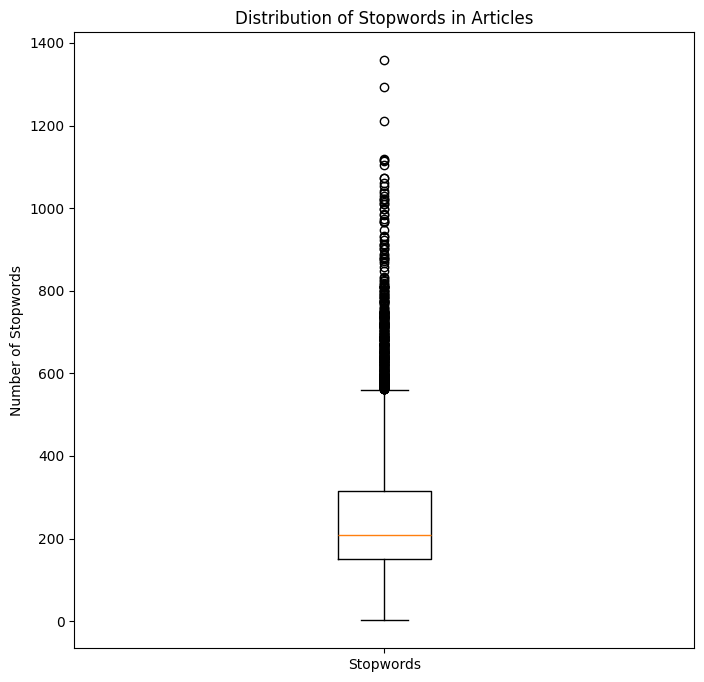

In [227]:
# Boxplot: Distribution of Stopwords in Articles"
plt.figure(figsize=(8, 8))
plt.boxplot(df["stopwords"])
plt.ylabel("Number of Stopwords")
plt.title("Distribution of Stopwords in Articles")
plt.xticks([1], ["Stopwords"])
plt.show()

### Number of numerics

In [233]:
df['numerics'] = df['article'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['article','numerics']]

,article,numerics
1,twitter kinh_doanh ra sao sau một năm về tay e...,0
2,thương_mại nga trung gần như_không còn dùng us...,0
3,ngân_hàng nhà_nước khó xử_lý sở_hữu chéo nếu c...,0
4,doanh_nghiệp đào_tạo nhân_viên thành tiktoker ...,0
5,khách hỏi mua hàng việt trên alibaba tăng cao ...,0
...,...,...
6762,thanh thảo nhận vé vớt vietnam idol tp hcm tha...,0
6763,loạt tác_phẩm trừu_tượng màu trắng của trần nữ...,0
6764,hà_trí quang mang sổ_đỏ tỷ đồng hỏi cưới đồng ...,0
6765,con_gái xuân_lan diễn loạt show thời_trang bé ...,0


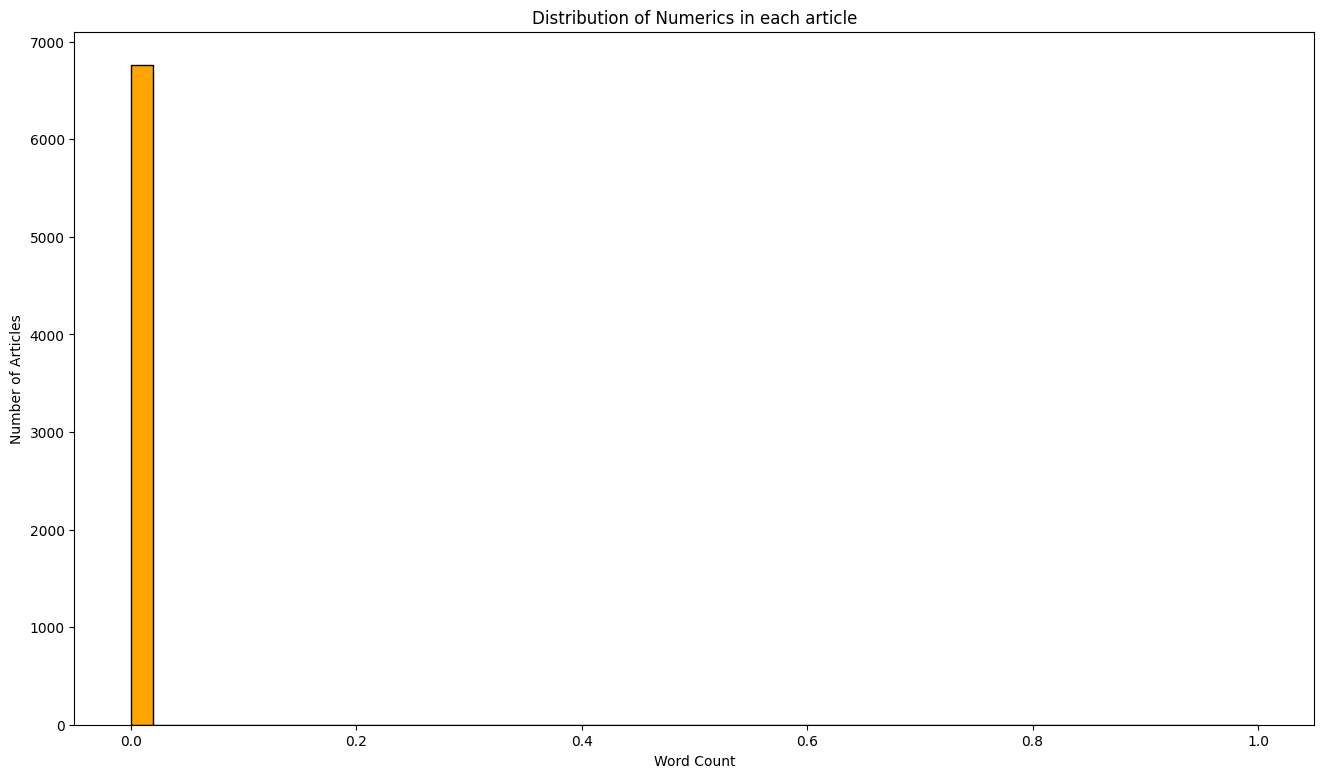

In [237]:
# Histogram: Numerics counts per article
fig = plt.figure(figsize=(16,9))
plt.hist(df['numerics'], bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Numerics in each article')
plt.xlabel('Word Count')
plt.ylabel('Number of Articles')
plt.show()

So, there is no number in the article dataset